In [43]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as mp
import seaborn as sb

from scipy.stats import f_oneway

db = sqlite3.connect('../data/movies_project.db')

# Load tables
movies_df = pd.read_sql_query("SELECT * FROM movies", db)
starring_df = pd.read_sql_query("SELECT * FROM starring", db)
genres_df = pd.read_sql_query("SELECT * FROM genres", db)
directors_df = pd.read_sql_query("SELECT * FROM directors", db)
platforms_df = pd.read_sql_query("SELECT * FROM platforms", db)

#### Phase 1: Popularity & Quality Drivers
What actually drives movie success?

A peak into the highest budget films and how their ratings compare.

In [33]:
query = """
SELECT m.year, m.title, m.ratings,m.budget
from platforms p
INNER JOIN movies m on m.title = p.title
WHERE m.budget > 0 and m.ratings > 0
ORDER BY m.budget desc, m.ratings desc,p.`rotten_tomatoes`desc;
"""

q1=pd.read_sql_query(query,db)
display(q1.head(100))

,year,title,ratings,budget
0,2019.0,Star Wars: The Rise Of Skywalker,6.3,416000000
1,2015.0,Avengers: Age Of Ultron,7.3,365000000
2,2019.0,Avengers: Endgame,8.3,356000000
3,2018.0,Avengers: Infinity War,8.3,300000000
4,2007.0,Pirates Of The Caribbean: At World'S End,7.2,300000000
...,...,...,...,...
95,2008.0,Bolt,6.6,150000000
96,2008.0,Madagascar: Escape 2 Africa,6.6,150000000
97,2009.0,X-Men Origins: Wolverine,6.4,150000000
98,2008.0,Hancock,6.4,150000000


One common assumption is that bigger movie budgets lead to higher quality films (as reflected in ratings).  
To test this, I ran two correlation analyses:
note: n = 1, 0, or -1 signify a strong correlation.

- **Pearson correlation**: tests for linear relationships.  
- **Spearman correlation**: tests for monotonic (rank-based) relationships.  

### Budget vs. Ratings

In [34]:
filtered_movies = movies_df.loc[(movies_df['revenue']>0)&(movies_df['budget']>= 900000)]


#### Pearson Test


In [35]:
movies_df['budget'].corr(movies_df['ratings'],method = 'pearson')

np.float64(0.07225297849393057)

#### Spearman rank test


In [36]:
movies_df['budget'].corr(movies_df['ratings'],method = 'spearman')

np.float64(0.07441305913183667)

In [37]:
filtered_movies['budget'].corr( filtered_movies['ratings'],method = 'pearson')

np.float64(0.08639063166073933)

In [38]:
filtered_movies['budget'].corr( filtered_movies['ratings'],method = 'spearman')

np.float64(0.022031833596327027)

#### Findings:
- Initial Pearson correlation ≈ 0.072 → very weak linear relationship.  
- Spearman correlation ≈ 0.074 → very weak monotonic relationship.  
- After filtering out placeholder revenues (revenue = 0), correlation values rose closer to 0 (Pearson ≈ 0.141, Spearman ≈ 0.132).

**Result:**  
Movie budget is not a reliable predictor of a film's critical or audience rating. Both high-budget blockbusters and low-budget independent films can achieve a wide range of ratings, demonstrating that cost does not correlate strongly with perceived quality

#### Influence of Lead Actors

Many actors appear in a wide range of films, so their average rating can vary widely.  
To make the test more reliable:
- Only films with at least 665 votes were included (to reduce noise from niche/low-visibility films).  
- Actors were grouped by their lead roles (`ord = 1`).  

Question *Do popular lead actors or directors influence ratings or budgets?*

In [39]:
query = """
SELECT 
    s.actor, 
    count(*) as lead_roles, 
    avg(m.ratings) as averages
FROM starring s
INNER JOIN movies m on m.id = s.movie_id
WHERE s.ord = 1 and m.ratings > 0
GROUP BY s.actor
ORDER BY count(*) desc, averages desc;
"""

q2=pd.read_sql_query(query,db)
display(q2.head(20))

,actor,lead_roles,averages
0,Mel Blanc,700,6.142286
1,James A. Fitzpatrick,193,4.179793
2,Jack Mercer,159,5.254717
3,Tim Turner,123,3.447967
4,Mae Questel,122,5.618852
5,Daws Butler,120,5.674167
6,Georges Méliès,114,5.592105
7,Clarence Nash,106,6.623585
8,Pinto Colvig,101,6.286139
9,Walt Disney,91,6.163736


Based on industry standards, a movie is at least 40 minutes so I will filter accordingly.

In [40]:
query = """
SELECT 
    s.actor, 
    count(*) as lead_roles, 
    avg(m.ratings) as averages
FROM starring s
INNER JOIN movies m on m.id = s.movie_id
WHERE s.ord = 1 and m.ratings > 0 and m.minutes >= 40
GROUP BY s.actor
ORDER BY count(*) desc,averages desc;
"""

q2=pd.read_sql_query(query,db)
display(q2.head(20))

,actor,lead_roles,averages
0,David Attenborough,72,7.422222
1,Mithun Chakraborty,59,4.867797
2,Jagathy Sreekumar,59,4.544068
3,Madan Puri,55,4.921818
4,Brahmanandam,48,4.714583
5,Sujit Kumar,47,4.574468
6,Prem Chopra,44,4.727273
7,Manorama,43,4.951163
8,Helen,43,4.425581
9,Juhi Chawla Mehta,42,5.223810



Based on the data David Attenborough holds the highest lead roles with amongst the highest average rating, 72 roles at 7.4.
However, generally the ratings seem to range from 3.7 to 5.2. On another note, an outlier in this top 20 list shows André Rieu	
having the highest rating at 8.3 having 38 roles.

After review, I'd like to consider using the bottom percentile of vote counts as I found there to be some placeholders in the data that may contribute to the extreme skewedness. 25th = `665`.

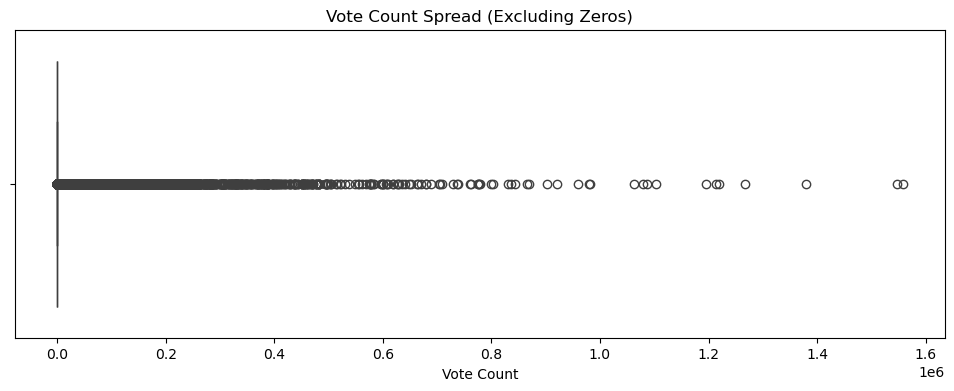

In [41]:
mp.figure(figsize = (12,4))
sb.boxplot(x=movies_df[movies_df['count']>0]['count'])
mp.title("Vote Count Spread (Excluding Zeros)")
mp.xlabel("Vote Count")
mp.show()

- **Median vote count:** 7,126  
- **Mean vote count:** 36,002 

Test: *ANOVA does the mean ratings differ significantly depending on the actor?*                        

In [45]:


# Include only vote counts of 665+ for reliability
lead_df = (starring_df[starring_df['ord']==1]
          .merge(
              movies_df[['id','ratings','count']],
              left_on = 'movie_id',
              right_on='id'
          )
          )

actor_avg = (
    lead_df[lead_df['count'] >= 665]
    .groupby('actor',as_index=False)
    .agg(
        lead_count = ('movie_id','count'),
        avg_ratings= ('ratings','mean')
        )
    .sort_values(by =['lead_count','avg_ratings'],ascending=[False,False])
            )

In [46]:
groups = [grp['ratings'].values for _ , grp in lead_df[lead_df['count']>= 665].groupby('actor')]

f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

F-statistic: 1.65, p-value: 0.0000


#### Results:
- **F-statistic**: 1.65 
- **p-value**: < 0.005  

Interpretation:  
Since the p-value is below 0.05, we reject the null hypothesis that the average rating is consistent amongst each actor.
This means that **average ratings do differ significantly depending on the lead actor**.  

However, the F-statistic is fairly low (1.65), suggesting that while the effect is statistically significant, the **magnitude of the effect may not be strong**.  

In [48]:
top_actors = (actor_avg[actor_avg['lead_count'] >= 10]
              .sort_values(by='lead_count', ascending=False)
              .head(10)['actor'])

subset = lead_df[lead_df['actor'].isin(top_actors) & (lead_df['count'] >= 665)]

from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(
    endog=subset['ratings'],
    groups=subset['actor'],
    alpha=0.05
)
print(tukey.summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
   Anupam Kher  Clarence Nash   0.7429 0.0323  0.0326  1.4531   True
   Anupam Kher Dave Chappelle   1.2725    0.0  0.4797  2.0654   True
   Anupam Kher    Elijah Wood   0.2341 0.9947 -0.5588  1.0269  False
   Anupam Kher  Emraan Hashmi  -0.6429 0.2042 -1.4209  0.1352  False
   Anupam Kher Georges Méliès   0.3071 0.9428 -0.4264  1.0407  False
   Anupam Kher   Jim Cummings   0.2929 0.9708 -0.4852  1.0709  False
   Anupam Kher      Mel Blanc   1.0275    0.0  0.4201  1.6348   True
   Anupam Kher    Prakash Raj  -0.0116    1.0 -0.7649  0.7417  False
   Anupam Kher  Ricky Gervais   1.1905 0.0002  0.3807  2.0003   True
 Clarence Nash Dave Chappelle   0.5297 0.3719 -0.1968  1.2561  False
 Clarence Nash    Elijah Wood  -0.5088 0.4317 -1.2352  0.2176  False
 Clarence Nash  Emraan Hashmi  -1.

Post hoc analysis with Tukey’s HSD was conducted on the top lead actors to identify which actor pairs had significantly different average ratings.

- The most extreme differences include:
  - **Dave Chappelle vs Emraan Hashmi:** Chappelle’s films rated ~1.9 points lower (p < 0.001)
  - **Prakash Raj vs Ricky Gervais:** Raj’s films rated ~1.2 points higher (p < 0.001)
  - **Clarence Nash vs Emraan Hashmi:** Nash’s films rated ~1.39 points lower (p < 0.001)

These results indicate that some lead actors appear more frequently in higher-rated films, but many actors show no significant difference in ratings relative to their peers. Overall, actor identity explains **some, but not all, variation** in movie ratings.

In [49]:
query = """
SELECT 
    s.actor, 
    count(*) as lead_roles, 
    avg(m.ratings) as averages
FROM starring s
INNER JOIN movies m on m.id = s.movie_id
WHERE s.ord = 1 and count >= 665
GROUP BY s.actor
ORDER BY count(*) desc,averages desc;
"""

q2=pd.read_sql_query(query,db)
display(q2.head(20))

,actor,lead_roles,averages
0,Mel Blanc,64,7.270313
1,Clarence Nash,21,6.985714
2,Georges Méliès,18,6.550000
3,Prakash Raj,16,6.231250
4,Jim Cummings,14,6.535714
5,Anupam Kher,14,6.242857
6,Emraan Hashmi,14,5.600000
7,Dave Chappelle,13,7.515385
8,Elijah Wood,13,6.476923
9,Ricky Gervais,12,7.433333


#### Influence of Directors

Similarly, I tested whether certain directors are consistently associated with higher-rated films.  

In [50]:
query = """
WITH director_leads AS (
SELECT 
    d.*,
    ROW_NUMBER() OVER (PARTITION BY d.movie_id ORDER BY d.rowid) as rn
FROM directors d
)

SELECT 
    dl.director, 
    count(*) as lead_roles, 
    avg(m.ratings) as averages
FROM director_leads dl
INNER JOIN movies m ON m.id = dl.movie_id
WHERE dl.rn = 1 AND m.count >= 665
GROUP BY dl.director
ORDER BY count(*) desc, avg(m.ratings) desc;
"""

q20=pd.read_sql_query(query,db)
display(q20.head(20))

,director,lead_roles,averages
0,Alfred Hitchcock,54,6.775926
1,Woody Allen,52,6.817308
2,Charlie Chaplin,50,6.724000
3,Chuck Jones,49,7.391837
4,Michael Curtiz,47,6.712766
5,John Ford,46,6.882609
6,Werner Herzog,42,6.961905
7,Ingmar Bergman,41,7.256098
8,Raoul Walsh,41,6.619512
9,Takashi Miike,41,6.521951


In [51]:
#Same filtering as SQL, however, seeking level of significance.
lead_directors = (
    directors_df
    .groupby('movie_id', as_index=False)
    .head(1)
    .rename(columns={'director':'lead_director'})
)
# preserve current row order explicitly, then pick first per movie
tmp = directors_df.reset_index().rename(columns={'index':'row_order'})
lead_directors = (
    tmp.loc[tmp.groupby('movie_id')['row_order'].idxmin()]
       .rename(columns={'director':'lead_director'})
       .drop(columns=['row_order'])
)


lead_directors = lead_directors.merge(
    movies_df[['id','ratings','count']],
    left_on='movie_id', right_on='id', how='inner'
)

lead_directors = lead_directors[lead_directors['count'] >= 665]

director_stats = (
    lead_directors.groupby('lead_director', as_index=False)
    .agg(lead_count=('movie_id','count'),
         avg_rating=('ratings','mean'))
    .sort_values(['lead_count','avg_rating'], ascending=[False, False])
)

groups = [g['ratings'].values for _, g in lead_directors.groupby('lead_director')]
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")


F-statistic: 4.28, p-value: 0.0000


In [52]:
# Filter for top directors with sufficient number of movies and reliable vote counts
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Merge directors with movie ratings and vote counts
lead_directors_df = directors_df.merge(
    movies_df[['id','ratings','count']],
    left_on='movie_id',
    right_on='id'
)

# Filter for reliable vote counts (same as actors)
lead_directors_df = lead_directors_df[lead_directors_df['count'] >= 665]

# Identify top 10 directors by number of movies
top_directors = (
    lead_directors_df.groupby('director')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Subset for top directors only
subset_directors = lead_directors_df[lead_directors_df['director'].isin(top_directors)]

# Tukey HSD post hoc test
tukey_directors = pairwise_tukeyhsd(
    endog=subset_directors['ratings'],
    groups=subset_directors['director'],
    alpha=0.05
)

# Display results
print(tukey_directors.summary())


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2     meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------------
Alfred Hitchcock Charlie Chaplin   -0.074 0.9998 -0.4448  0.2968  False
Alfred Hitchcock     Chuck Jones   0.6041    0.0  0.2314  0.9768   True
Alfred Hitchcock       John Ford   0.1092 0.9959 -0.2697   0.488  False
Alfred Hitchcock  Joseph Barbera   0.5521 0.0001  0.1794  0.9248   True
Alfred Hitchcock  Michael Curtiz  -0.0426    1.0 -0.4193  0.3341  False
Alfred Hitchcock   Takashi Miike  -0.2474 0.5906 -0.6381  0.1434  False
Alfred Hitchcock   Werner Herzog   0.1968  0.837 -0.1889  0.5825  False
Alfred Hitchcock   William Hanna   0.5521 0.0001  0.1794  0.9248   True
Alfred Hitchcock     Woody Allen   0.0414    1.0 -0.3276  0.4104  False
 Charlie Chaplin     Chuck Jones    0.678    0.0  0.3001   1.056   True
 Charlie Chaplin       John Ford   0.1831 0.8854 -0.2008  0.5671

Post hoc analysis with Tukey’s HSD was conducted on the top 10 lead directors to identify which pairs had significantly different average movie ratings.

The largest differences include:
- **Takashi Miike vs Chuck Jones:** Miike’s films rated ~0.85 points lower (p < 0.001)
- **Takashi Miike vs William Hanna:** Miike’s films rated ~0.80 points lower (p < 0.001)
- **Joseph Barbera vs Takashi Miike:** Barbera’s films rated ~0.80 points higher (p < 0.001)
- **Alfred Hitchcock vs Chuck Jones:** Hitchcock’s films rated ~0.60 points higher (p < 0.001)

These results suggest that while some directors consistently appear in higher- or lower-rated films, many director pairs show no significant difference, indicating that **director identity partially contributes to movie ratings**, but it is not the sole driver.


#### Findings:
While a director can have a consistent influence on film quality, their identity is not a universal predictor of a movie's ratings. This analysis confirms that budget is a poor indicator of success and that a film's quality is a complex, multifaceted outcome stemming from creative talent rather than financial investment alone.